# Statistical arbitrage on cryptocurrencies
By Rodrigues Thomas, Roure Clement and Sirot Antoine

### In this project we have priced the 10 cryptocurrencies listed below in order to perform a statistical arbitrage on them in order to obtain a thoughtful trading algorithm:


In [1]:
token_list = ['BTC', 'ETH', 'BNB', 'SOL', 'MATIC', 'SHIB', 'DOGE', 'ADA', 'ETC', 'AVAX']

All imports necessary for the project:

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import itertools
import seaborn as sns


from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from datetime import datetime
from pandas import json_normalize
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

First we needed to retrieve the prices of these 10 crypto-currencies over the last 4 months (500 values). For this we used the Binance API which allows us to retrieve all the prices without any problem. Then we stored them in a different json file for each cryptocurrency.

The function dataOfTokenPair uses the Binance API with a pair of crypto-currencies and a candle duration.

The implementFiles function calls the previous function and will enter the data into the files.

In [3]:
def dataOfTokenPair(pair, duration):
    d = requests.get('https://data.binance.com/api/v3/klines?symbol='+pair+'&interval='+duration).json()    
    L2=[]
    L3=[]
    for i in range (len(d)):
        L2.append(datetime.fromtimestamp(d[i][0]/1000).strftime("%Y-%m-%d %I:%M:%S"))
        L2.append(d[i][1])
        L3.append(L2)
        L2=[]


    data = []
    for period in L3:
        time_period_start = period[0]
        price_open = float(period[1])

        time_period_start = time_period_start[:10] + ' ' + time_period_start[11:19]

        data.append({
            "time_period_start": time_period_start,
            "price_open": price_open
        })
    return data

def implementFiles():
    for token in token_list: # Run over the token list
        x = dataOfTokenPair(token +'USDT', '6h')
        with open('{}.json'.format(token), 'w') as outfile:
            json.dump(x, outfile)
            
implementFiles()

After that we created our DataFrame with all our values in order to be able to compare the evolution of the different cryptocurrencies:

In [4]:

datetime_index = pd.date_range('2023-02-09 08:00:00', '2023-02-05 04:00:00', freq='4H')
df = pd.DataFrame(index = datetime_index)

for token in token_list: # Run over the token list
    with open('{}.json'.format(token)) as json_data: 
        full_data = json_normalize(json.load(json_data)) 
        price_data = full_data['price_open']
        date = full_data['time_period_start']
        formatted_date = []
        for i in date: 
            formatted_date.append(pd.to_datetime(i[0:4] + '-' + i[5:7] + '-' + i[8:10] + ' ' + i[11:13] + ':00:00'))
        tokendf = pd.DataFrame(index = list(formatted_date)) 
        tokendf['{}'.format(token)] = price_data.values 
        df = pd.concat([df, tokendf], axis=1, sort=False) 
        

df.describe()

,BTC,ETH,BNB,SOL,MATIC,SHIB,DOGE,ADA,ETC,AVAX
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,18398.860400,1337.568640,279.284600,23.172660,0.856813,0.000010,0.077863,0.365313,23.527520,15.224340
std,1637.597367,153.272157,23.256564,9.738335,0.090523,0.000001,0.019813,0.075336,6.217263,2.774154
min,15747.880000,1085.440000,228.800000,9.120000,0.700600,0.000008,0.056590,0.241500,15.120000,10.720000
25%,16815.552500,1219.965000,268.450000,13.485000,0.795875,0.000009,0.060777,0.311325,19.187500,12.867500
50%,18868.515000,1291.645000,276.800000,28.225000,0.842200,0.000010,0.072600,0.357800,22.680000,15.575000
75%,19599.785000,1362.172500,290.450000,32.540000,0.902900,0.000011,0.088167,0.428575,27.442500,17.352500
max,22522.740000,1774.120000,360.100000,38.460000,1.268500,0.000014,0.145930,0.515800,40.560000,21.560000


In order to better visualize our dataset we normalized the values and displayed the price curves of each cryptocurrency :

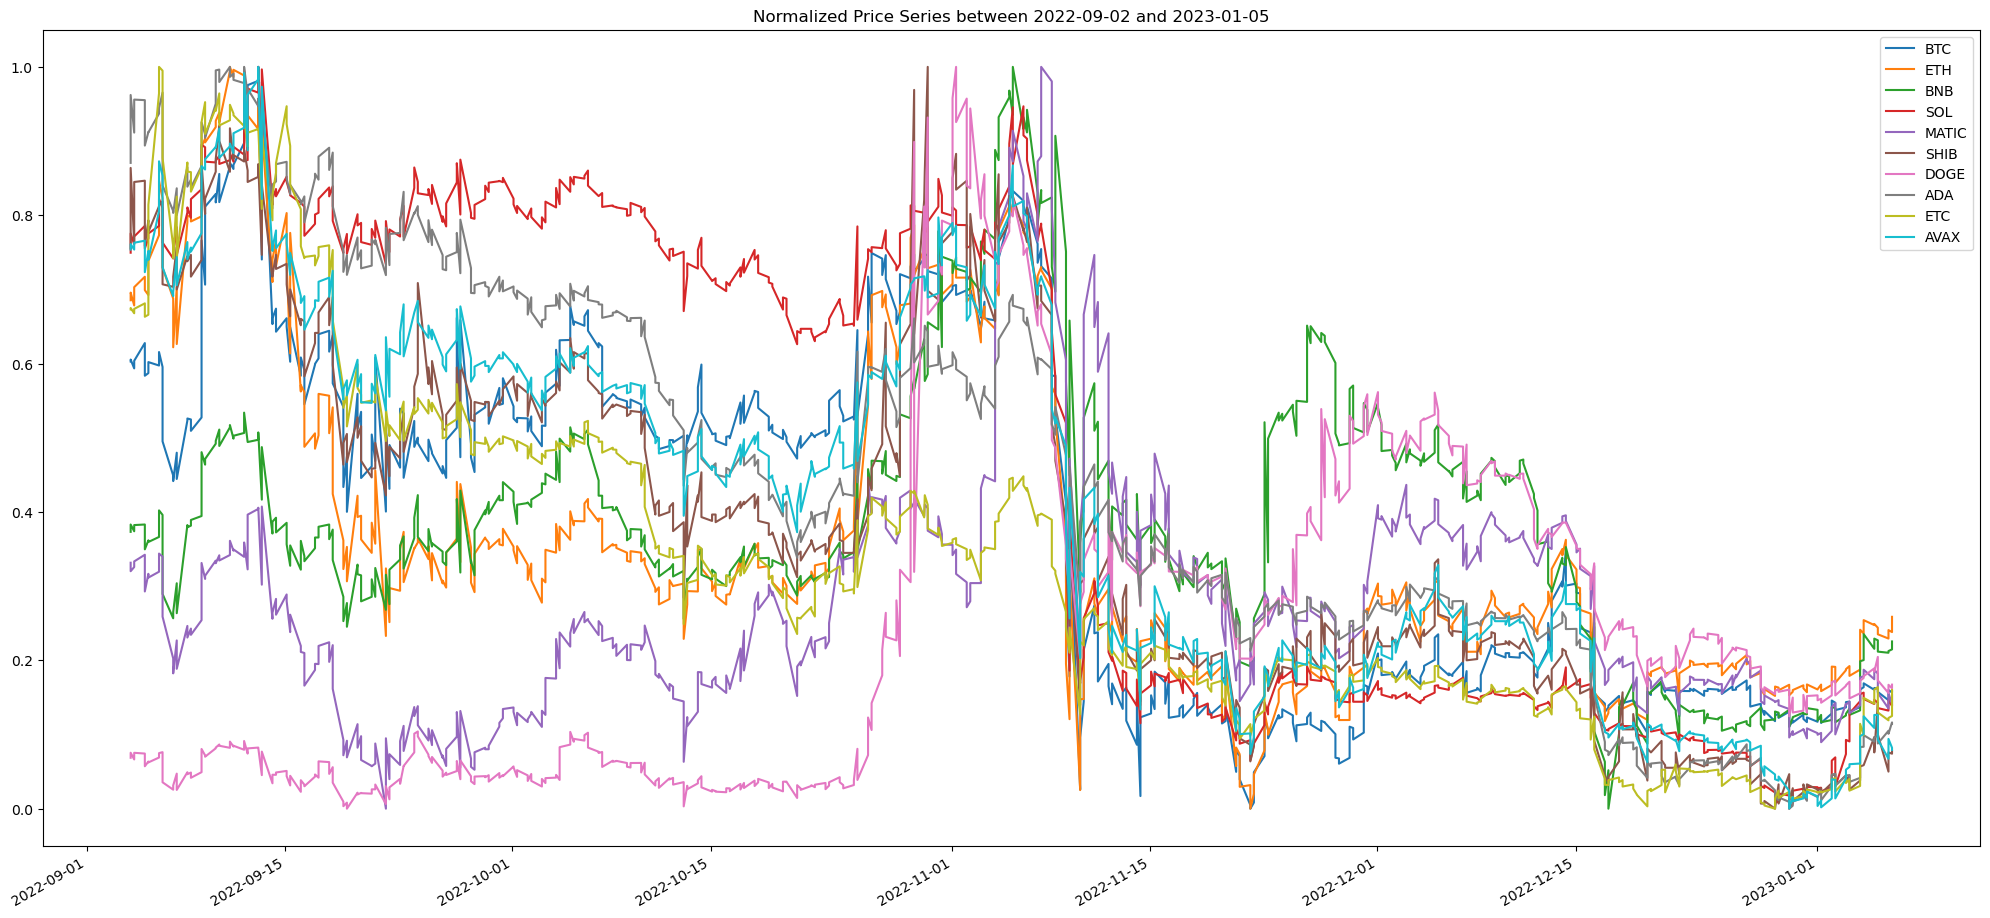

In [5]:
normalized_df=(df-df.min())/(df.max()-df.min()) 
normalized_df.plot(figsize=(25,12), title='Normalized Price Series between 2022-09-02 and 2023-01-05');

## Augmented Dickey-Fuller Test 

In order to a better understanding of the cointegration we created a table with every cointegration using the Augmented Dickey-Fuller Test :

In [6]:

t_results_table = pd.DataFrame(columns=token_list, index=token_list)
p_results_table = pd.DataFrame(columns=token_list, index=token_list) 

for row in token_list:
    for column in token_list:

        if row == column: 
            t_results_table[column][row] = np.nan
            p_results_table[column][row] = np.nan
            
        else: 
            regression = sm.OLS(df[row], sm.add_constant(df[column])).fit().params 
            residual = df[row]-regression[1]*df[column]-regression[0] 
            adf_results = adfuller(residual) 
            t_results_table[column][row] = adf_results[0] 
            p_results_table[column][row] = adf_results[1]

t_results_table.head(len(token_list))

,BTC,ETH,BNB,SOL,MATIC,SHIB,DOGE,ADA,ETC,AVAX
BTC,NaN,-1.810651,-1.514232,-3.448002,-1.36804,-3.352822,-1.732188,-2.317323,-2.166161,-3.239458
ETH,-2.82397,NaN,-2.273343,-2.481238,-2.522409,-2.733133,-2.174743,-2.360323,-2.483543,-2.379619
BNB,-1.980517,-2.082465,NaN,-1.871815,-2.803539,-2.503345,-1.977349,-2.241325,-2.142297,-1.982662
SOL,-3.075688,-1.255066,-0.925703,NaN,-0.846942,-2.092151,-1.3909,-2.379505,-1.638247,-2.005676
MATIC,-2.249023,-2.349939,-2.922535,-2.419963,NaN,-2.444097,-4.105454,-2.413815,-2.419458,-2.351462
SHIB,-3.134507,-1.748586,-2.095921,-2.538438,-1.657905,NaN,-1.606555,-3.042139,-2.501709,-3.355904
DOGE,-2.750303,-2.590315,-2.258574,-3.051592,-4.107163,-2.649395,NaN,-3.007128,-3.03317,-2.747347
ADA,-2.011474,-1.034926,-1.489547,-2.670281,-1.20841,-2.664846,-1.509462,NaN,-2.617106,-2.719828
ETC,-2.832814,-1.887914,-1.461109,-2.038846,-1.241698,-2.5737,-1.358856,-2.97249,NaN,-1.928403
AVAX,-3.103081,-0.892229,-1.459238,-2.212824,-1.000316,-3.151282,-1.365964,-2.696701,-1.85147,NaN


 We will now look for token pairs that have important cointegration and mean-reversion :

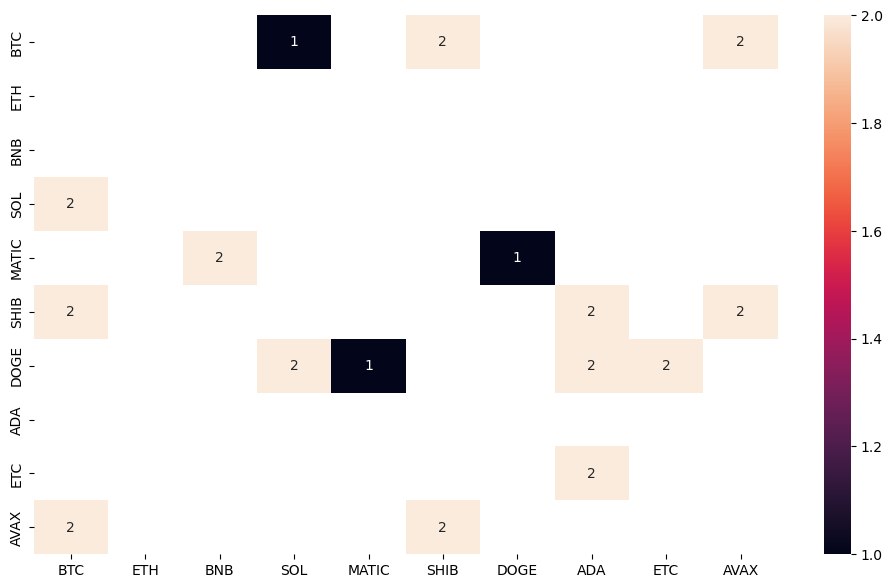

In [7]:
def tstat(cell):
    if cell < adf_results[4]['1%']:
        ret = 1
    elif cell < adf_results[4]['5%']:
        ret = 2
    else:
        ret = np.nan
    return ret

def convp(cell):
    if cell < 0.05:
        ret = 1
    else:
        ret = np.nan
    return ret

tstat_table = t_results_table.applymap(tstat)
pvalue_table = p_results_table.applymap(convp)

results_table = pd.DataFrame(tstat_table.values*pvalue_table.values, columns=tstat_table.columns, index=tstat_table.index)

fig = plt.figure(figsize=(12,7))
ax = sns.heatmap(results_table.values.astype(float), xticklabels = tstat_table.columns, yticklabels = tstat_table.columns, annot = True)

We can see that the pair with 2 has a result completed the Augmented Dickey-Fuller Test with a risk of 5% and those with 1 has completed it with 1% risk. These are the pairs that are most strongely cointegrated. From now on we have 14 combinaisons of pair possible.

## Hurst Exponent

In [8]:

#Hurst Exponent
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

Hurst_results_table = pd.DataFrame(columns=token_list, index=token_list)

for row in token_list:
    for column in token_list:
        if row == column:
            Hurst_results_table[column][row] = np.nan
        else:
            regression = sm.OLS(df[row], sm.add_constant(df[column])).fit().params    
            residual = df[row]-regression[1]*df[column]-regression[0]
            hurst_results = hurst(residual)
            Hurst_results_table[column][row] = hurst_results

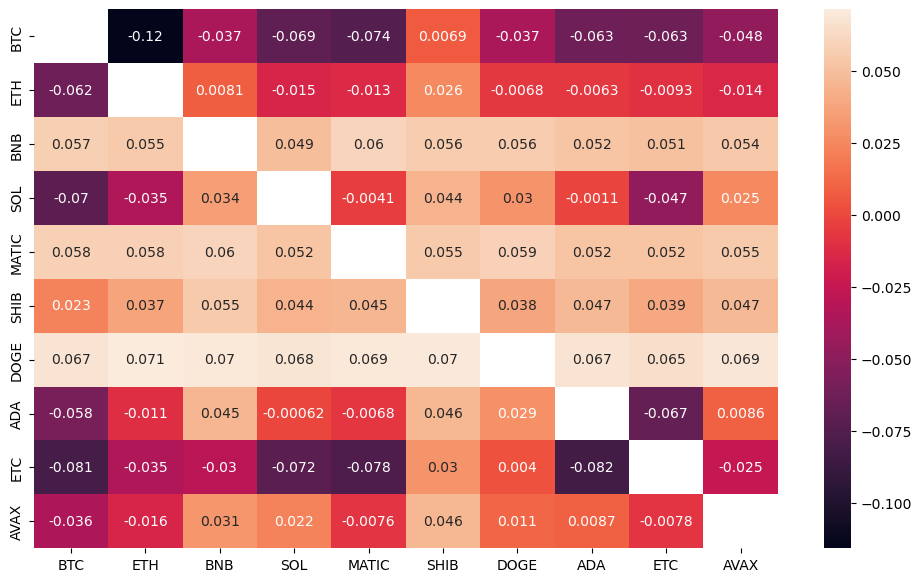

In [9]:

fig = plt.figure(figsize=(12,7))
ax = sns.heatmap(Hurst_results_table.values.astype(float), xticklabels = Hurst_results_table.columns, yticklabels = Hurst_results_table.columns, annot = True)

## Interpretation :

Here the values ain't coherent because they are all really close to 0. This can be a problem in our algorithm but we tried other codes, other methods and nothings works. We let an example that we tried below.

In [10]:
import itertools

# Initialize the results dataframe where we will store the Hurst exponents for each pair of tokens
hurst_results = pd.DataFrame(columns=token_list, index=token_list)

# Get every possible combination of tokens
combinations = list(itertools.combinations(df.columns, 2))

# Loop over the combinations
for row in combinations:
    # Calculate Hurst exponent for the pair of tokens
    hurst_exponent = hurst(df[list(row)].mean(axis=1))
    # Store the Hurst exponent in the results dataframe
    hurst_results.loc[row[0], row[1]] = hurst_exponent
    hurst_results.loc[row[1], row[0]] = hurst_exponent

# Print the results dataframe
print(hurst_results)


            BTC       ETH       BNB       SOL     MATIC      SHIB      DOGE  \
BTC         NaN -0.041566 -0.046129 -0.047371 -0.047497 -0.047505 -0.047504   
ETH   -0.041566       NaN  0.004482 -0.000979 -0.001655 -0.001699 -0.001692   
BNB   -0.046129  0.004482       NaN  0.043029  0.046336  0.046364  0.046362   
SOL   -0.047371 -0.000979  0.043029       NaN   0.00197  0.000929   0.00104   
MATIC -0.047497 -0.001655  0.046336   0.00197       NaN  0.051109  0.050714   
SHIB  -0.047505 -0.001699  0.046364  0.000929  0.051109       NaN  0.070056   
DOGE  -0.047504 -0.001692  0.046362   0.00104  0.050714  0.070056       NaN   
ADA   -0.047504 -0.001697  0.046321  0.000946  0.042473  0.001533  0.029172   
ETC   -0.047475 -0.001971  0.041611 -0.019692 -0.058332 -0.063093 -0.062629   
AVAX  -0.047447 -0.001545   0.04443 -0.000477  0.007976   0.00542  0.005718   

            ADA       ETC      AVAX  
BTC   -0.047504 -0.047475 -0.047447  
ETH   -0.001697 -0.001971 -0.001545  
BNB    0.046321 

After working on this project we only had results from the Augmented Dickey-Fuller State so we will try to trade from the supossed cointegration gave by him. We will take 3 pairs with 99% or sucess which are : SOL/BTC, MATIC/SOL, DOGE/MATIC 

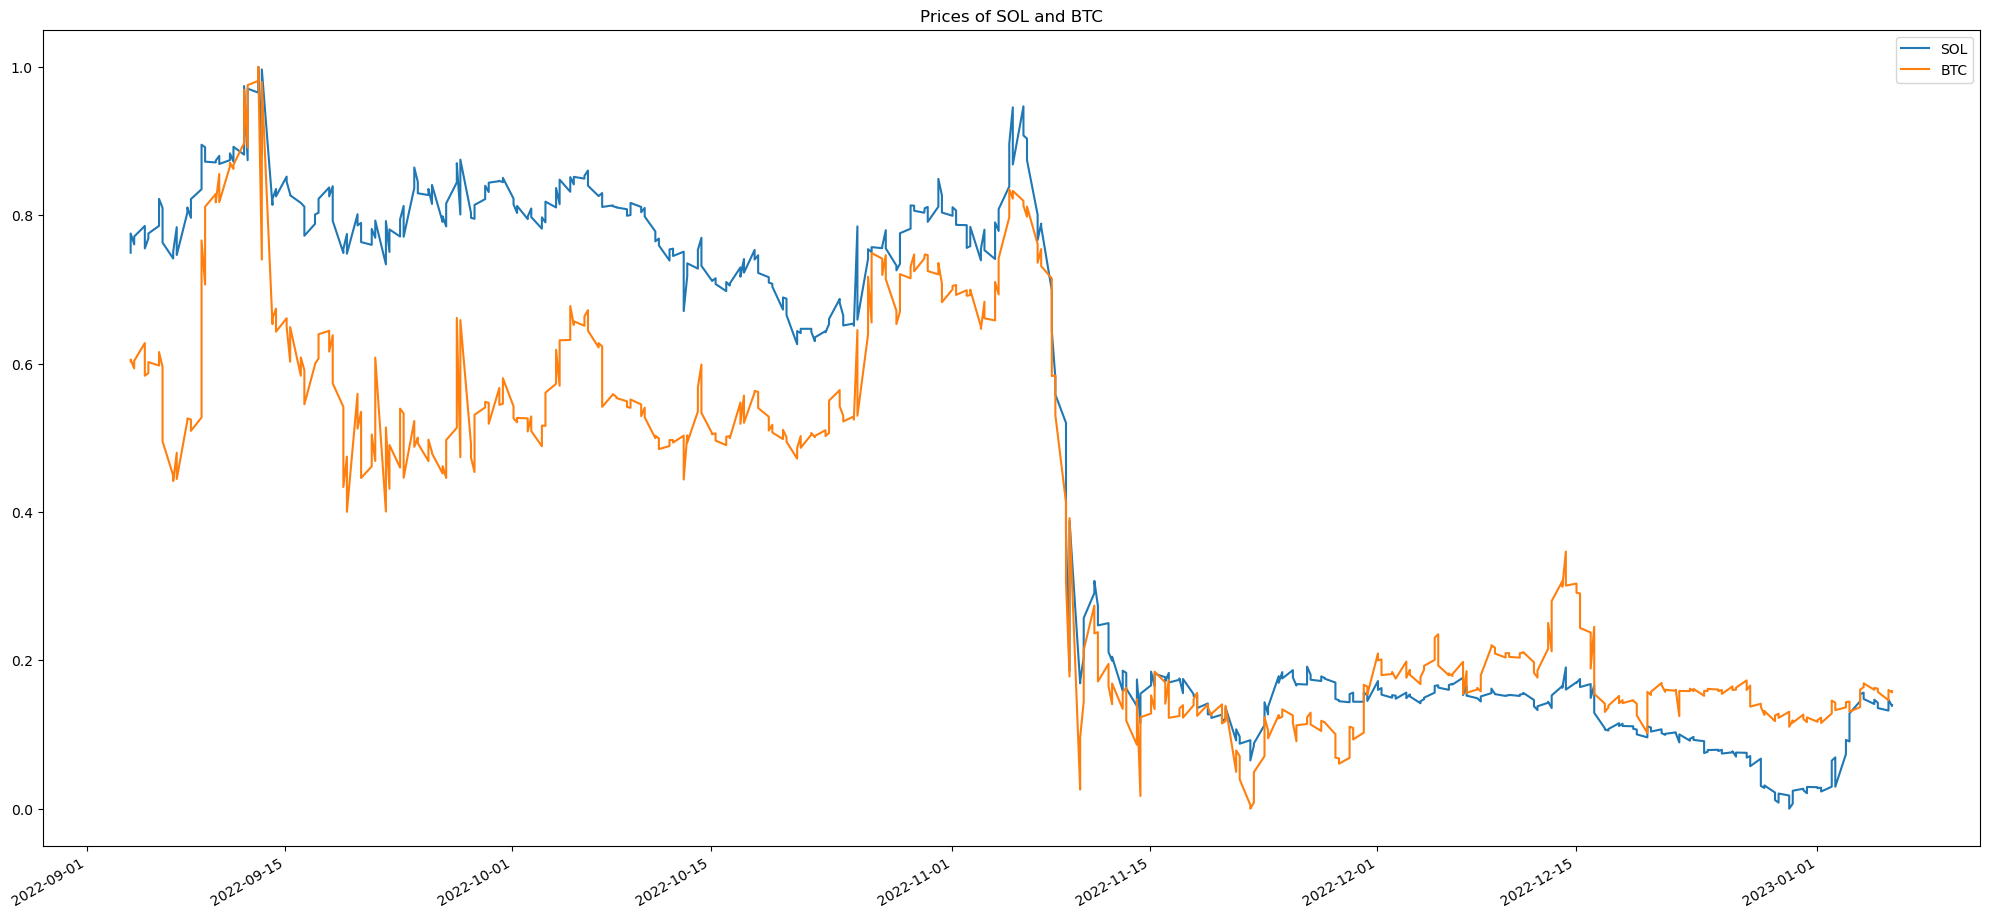

In [11]:
normalized_df=(df-df.min())/(df.max()-df.min()) 
subset_df = normalized_df.loc[:, ['SOL', 'BTC']]
subset_df.plot(figsize=(25,12), title = 'Prices of SOL and BTC');

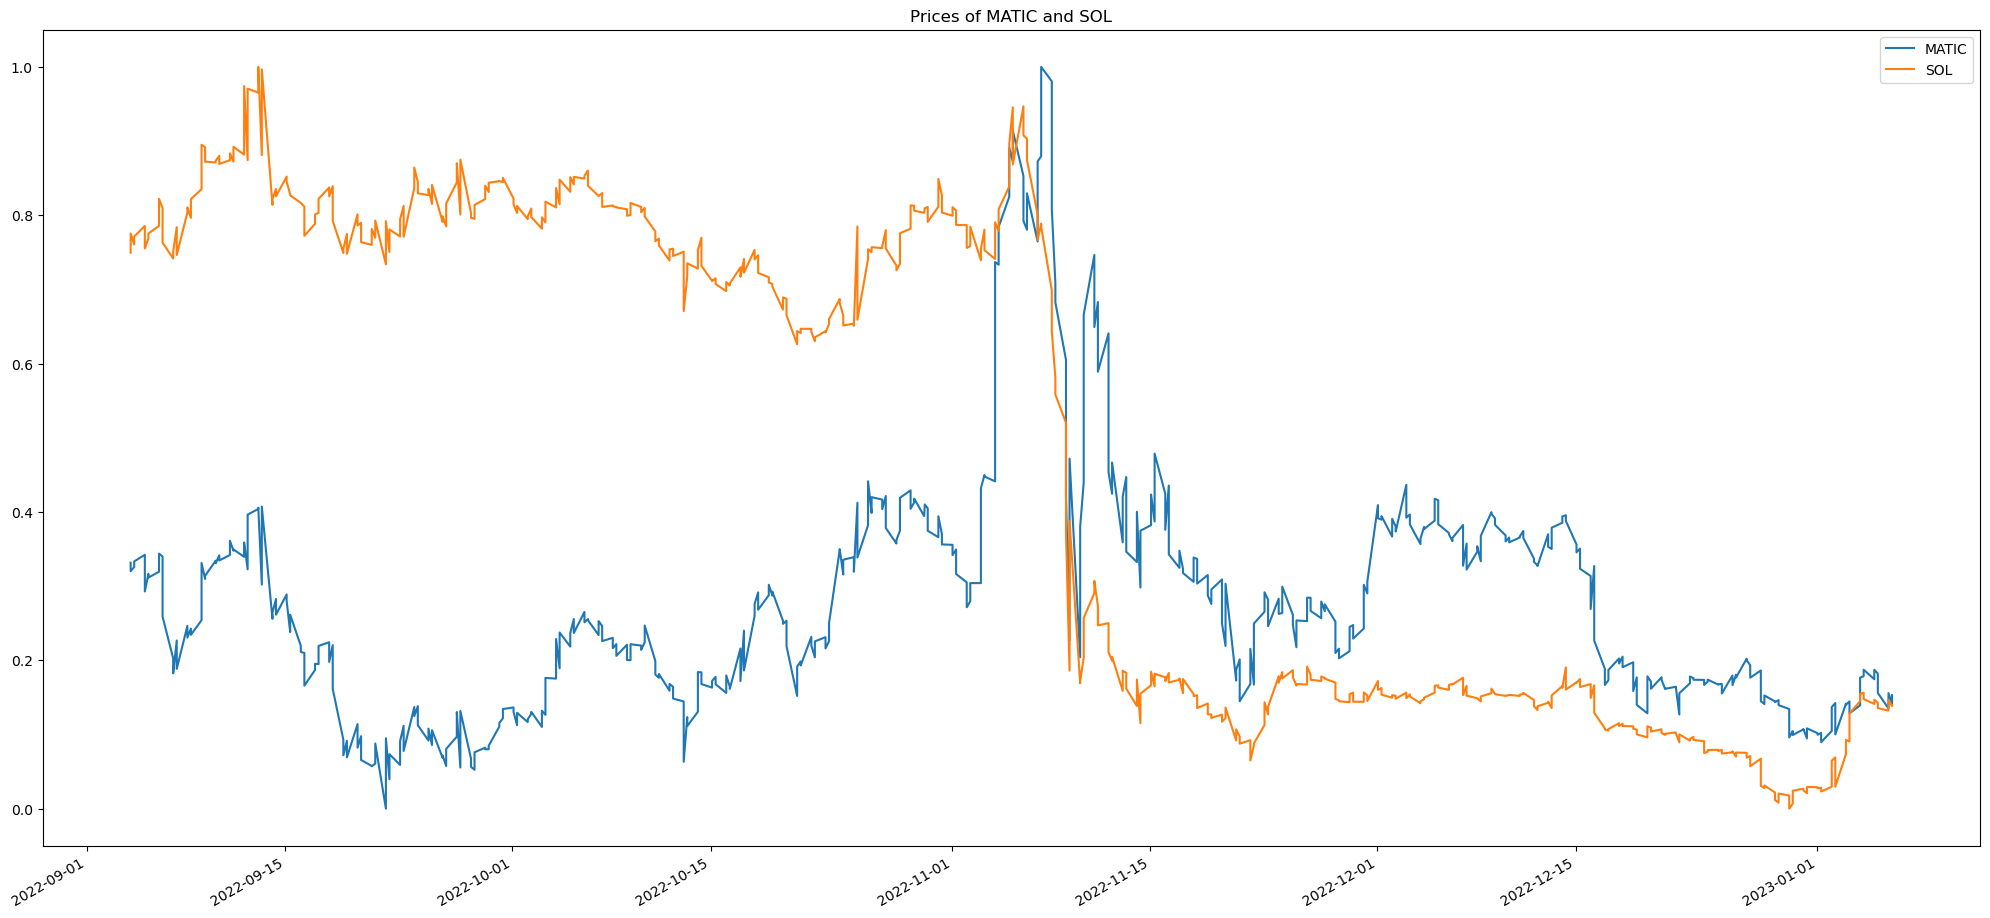

In [12]:
normalized_df=(df-df.min())/(df.max()-df.min()) 
subset_df = normalized_df.loc[:, ['MATIC', 'SOL']]
subset_df.plot(figsize=(25,12), title = 'Prices of MATIC and SOL');

<AxesSubplot:title={'center':'Prices of DOGE and MATIC'}>

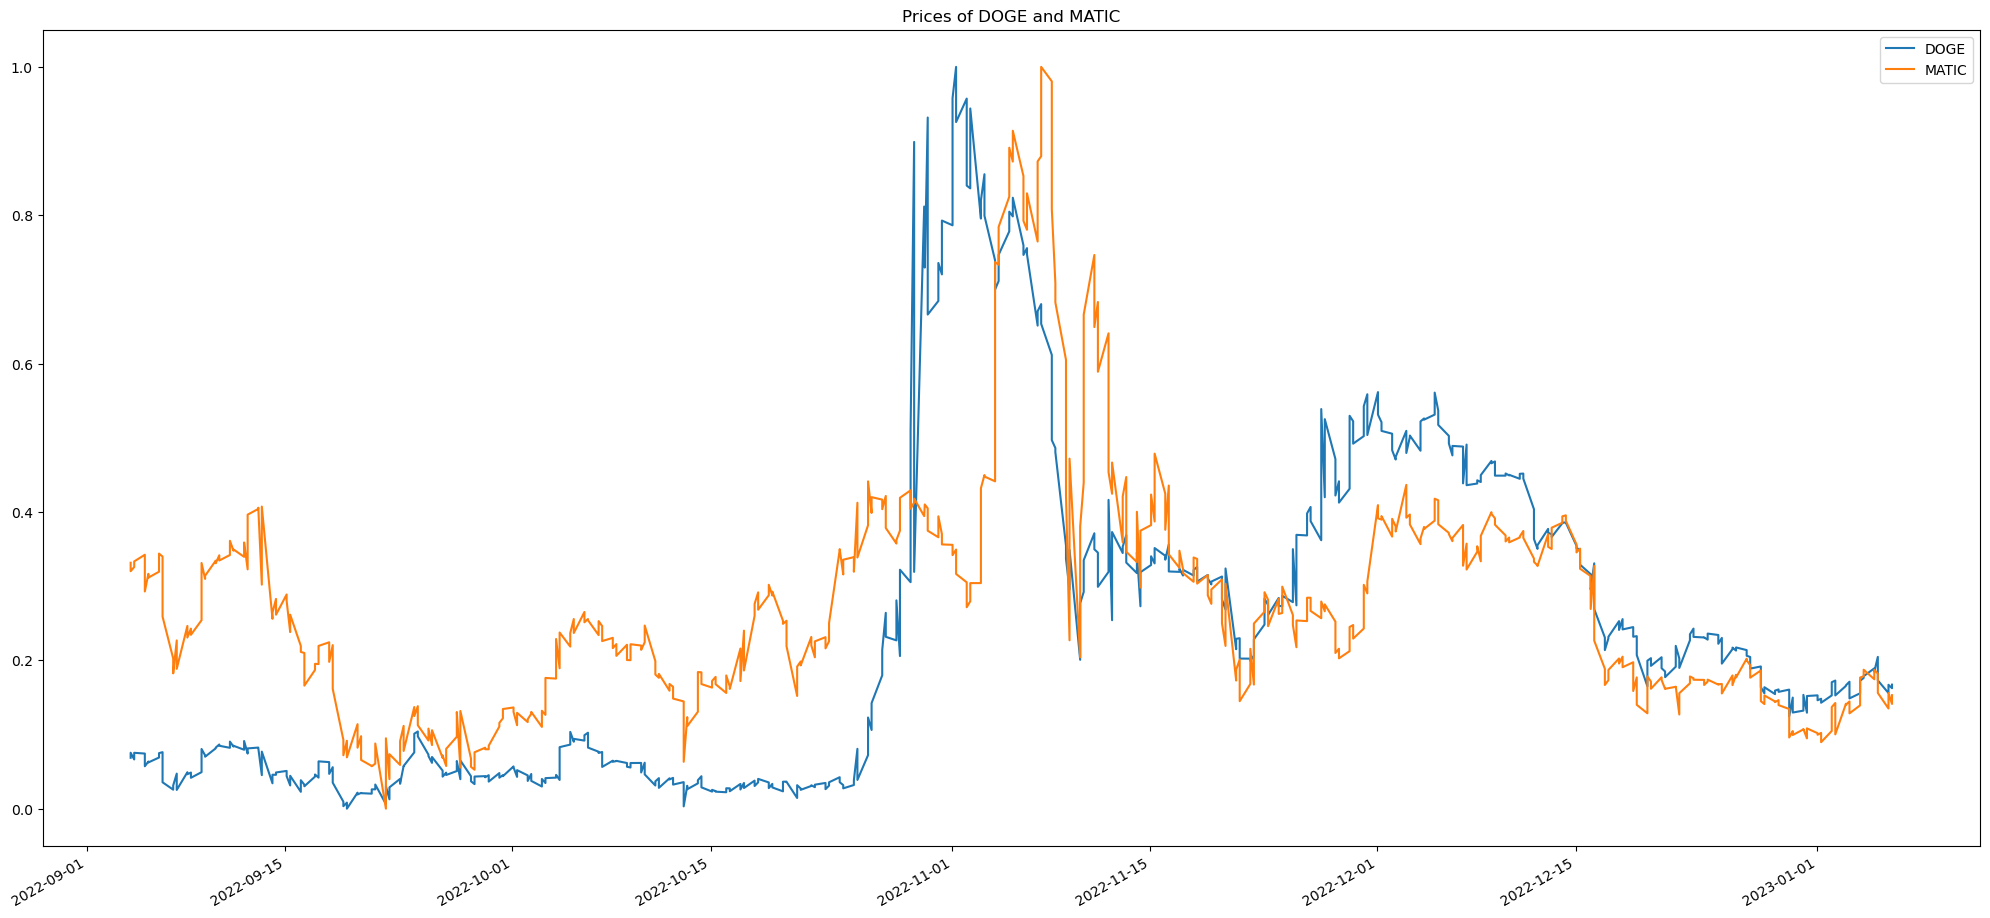

In [13]:
normalized_df=(df-df.min())/(df.max()-df.min()) 
subset_df = normalized_df.loc[:, ['DOGE', 'MATIC']]
subset_df.plot(figsize=(25,12), title = 'Prices of DOGE and MATIC')

## Trading
Peer trading is a long/short strategy based on pairs of cointegrated stocks. This quantitative method is based on this principle:
find two assets that have evolved in a similar way in the past. When the gap between the two widens, sell the higher asset and buy the lower asset. Based on their past behavior, the two prices should converge again and the investor, by closing his positions, should benefit from the observed gap. This technique is part of statistical arbitrage.

In [14]:
pip install cbpro

     ---------------------------------------- 1.3/1.3 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 584.6/584.6 kB 12.5 MB/s eta 0:00:00
     ------------------------------------- 196.2/196.2 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pymongo: filename=pymongo-3.5.1-cp39-cp39-win_amd64.whl size=273723 sha256=7ccd6500b044e46e451e9350ea25f9e32398a92d61cd67fd0b8d06b37c7d97f7
  Stored in directory: c:\users\oresm\appdata\local\pip\cache\wheels\4e\5f\18\dfaf703ab95483a1c3d3c8a82f39642eaabb71e05bb3beb770
  Created wheel for websocket-client: filename=websocket_client-0.40.0-py2.py3-none-any.whl size=198299 sha256=e3673684ccbfec6fb61133c3ffdca3d1f95c86f5992975373255300506a6731f
  Stored in directory: c:\users\oresm\appdata\local\pip\cache\wheels\46\7c\ba\aa37e3de9d0709e

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cookiecutter 1.7.3 requires requests>=2.23.0, but you have requests 2.13.0 which is incompatible.
conda 22.11.1 requires requests>=2.20.1, but you have requests 2.13.0 which is incompatible.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
conda-repo-cli 1.0.20 requires requests==2.28.1, but you have requests 2.13.0 which is incompatible.
anaconda-client 1.11.0 requires requests>=2.20.0, but you have requests 2.13.0 which is incompatible.
anaconda-client 1.11.0 requires six>=1.15.0, but you have six 1.10.0 which is incompatible.


In [15]:
# TRADING - Coinabse Pro

import cbpro
import base64
import json
from time import sleep

key = ''#insert your here
secret = ''
passphrase = ''

# Initialisation
encoded = json.dumps(secret).encode()
b64secret = base64.b64encode(encoded)
client = cbpro.AuthenticatedClient(key=key, b64secret=secret, passphrase=passphrase, api_url="https://api-public.sandbox.pro.coinbase.com/")
c = cbpro.PublicClient()

In [ ]:
def open_trade():
  try: 
    if sol < btc:
      try:
          # get current price of BTC-USD
          limit = c.get_product_ticker(product_id='BTC-USD')
      except Exception as e:
          print(f'Error obtaining ticker data: {e}')
          return

      buy_order = client.buy(product_id='SOL-USD', order_type="market", size=sol_amount)
      # sell_order = client.place_limit_order(product_id='BTC-USD', 
      #              side='sell', 
      #              price=float(limit['price']), 
      #              size= btc_amount)
      btcShorting = True

    # sol > btc
    else: 
      try:
          # get current price of SOL-USD
          limit = c.get_product_ticker(product_id='SOL-USD')
      except Exception as e:
          print(f'Error obtaining ticker data: {e}')
          return

      buy_order = client.buy(product_id='BTC-USD', order_type="market", size=btc_amount)
      # sell_order = client.place_limit_order(product_id='SOL-USD', 
      #              side='sell', 
      #              price=float(limit['price']), 
      #              size= sol_amount)
      btcShorting = False

  except Exception as e:
      print(f'Error placing order: {e}')
      return

  # wait for confirmation
  sleep(2)
  print(buy_order)

  try:
      check = buy_order['id']
      check_order = client.get_order(order_id=check)
  except Exception as e:
      print(f'Unable to check order. It might be rejected. {e}')
      return

  if check_order['status'] == 'done':
      print('Order placed successfully')
      print(check_order)
      # we are in a trade now
      isTrading = True
  else:
      print('Order was not matched')
      return

def close_trade():
  if btcShorting:
    # close sol long trade
    buy_order = client.sell(product_id='SOL-USD', order_type="market", size=sol_amount)
    # close btc short trade
    # sell_order = ?
  else:
    # close btc long trade
    buy_order = client.sell(product_id='BTC-USD', order_type="market", size=sol_amount)
    # close sol short trade
    # sell_order = ?

  # wait for confirmation
  sleep(2)
  print(buy_order)
  
  try:
      check = buy_order['id']
      check_order = client.get_order(order_id=check)
  except Exception as e:
      print(f'Unable to check order. It might be rejected. {e}')
  
  if check_order['status'] == 'done':
      print('Order placed successfully')
      print(check_order)
      # Trade closed successfully !
      isTrading = False
  else:
      print('WARNING: Order was not matched. Trades are still open !')
    

# Laisser l'algo tourner
# // Nous n'arrivons pas à effectuer d'ordre de short avec l'API de Coinbase Pro car il faut un compte de trading spécial pour les futures

# Main loop:
while True:

  # get latest data
  normalized_df=(df-df.min())/(df.max()-df.min()) 
  sol = normalized_df.loc[:, ['SOL']].iloc[-1].values[0]
  btc = normalized_df.loc[:, ['BTC']].iloc[-1].values[0]
  diff = abs(sol - btc)

  btc_amount = 0.001
  sol_amount = 1

  isTrading = False # Do we have an active trade ?
  btcShorting = False # If the trade is active: Are we longing or shorting the btc ?
  refresh_time = 3600 # In seconds

  print("SOL: " + str(round(sol,3)))
  print("BTC: " + str(round(btc,3)))
  print()

  if isTrading == False:
    # trigger treshold to open a trade
    if diff > 0.05:
      # open long + short trades
      open_trade()
    else:
       print("Conditions are not met to open a trade. Keep waiting...")
  else:
    # sol curve and btc curve touch or almost touch each others 
    # => Stop our trades and take profits !
    if diff < 0.001:
      close_trade()
    else:
      print("Conditions are not met to close our trade. Keep waiting...")

  sleep(refresh_time) # Refresh data after a certain time

SOL: 0.139
BTC: 0.158

Conditions are not met to open a trade. Keep waiting...


We can't place short orders on Coinbase Pro because we don't have a special Coinbase Futures account and the free api is restricted. 


The bot just place the long order when the 2 normalized prices difference is greater than the defined treshold. And it closes the trade when the normalized price become equal again.

The bot will buy the cryptocurrency with the lowest normalized price on the Spot market.

In [ ]:
# Cancel order -> Emergency quit
client.cancel_order(order_id = "trade-id")